In [1]:
# Import the python librarys
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns; sns.set()
import gzip
import os

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# read meta data
kegg_orgs = pd.read_csv('Kegg_ko_org_matrix_cols_index.txt', sep='\t', header=-1, names=['id', 'name', 'tree', 'tax_id'])
kegg_kos = pd.read_csv('Kegg_ko_org_matrix_rows_index.txt', sep='\t', header=-1, names=['id', 'desc'])

kegg_orgs[['taxa1','taxa2','taxa3','taxa4']]=pd.DataFrame(kegg_orgs.tree.str.split(';',3).tolist(), columns = ['taxa1','taxa2','taxa3','taxa4'])
kegg_orgs['taxa12'] = kegg_orgs[['taxa1', 'taxa2']].apply(lambda x: ';'.join(x), axis=1)
kegg_orgs['taxa123'] = kegg_orgs[['taxa12', 'taxa3']].apply(lambda x: ';'.join(x), axis=1)
kegg_orgs[kegg_orgs['taxa1']=='Eukaryotes'].shape

(356, 10)

In [3]:
print('KEGG Organisms',kegg_orgs.shape)
print('KEGG Orthology',kegg_kos.shape)

KEGG Organisms (4648, 10)
KEGG Orthology (20624, 2)


In [4]:
# read matrix (from csv)
data = []
with open('Kegg_ko_org_matrix.txt', 'r') as f:
    s = f.read()
    t = s.split('\n')
    for temp in t:
        data.append(list(temp))
kegg_ko_org_mat = np.array(data, dtype=np.uint8)

In [5]:
print('Matrix', kegg_ko_org_mat.shape)
int(kegg_ko_org_mat.shape[0]/64) + 1
np.sum(kegg_ko_org_mat, axis=0)

Matrix (20624, 4648)


array([1900, 1279, 1205, ..., 1229, 2915, 2844], dtype=uint64)

In [ ]:
def bin2uint64(arr):
    rst = 0
    for i in range(64):
        try:
            if arr[i]==1:
                rst += pow(2,i)
        except IndexError as e:
            break
    return rst

def binArr2uint64Arr(binArr):
    ngenes, ncols = binArr.shape
    print('0/1 matrix size: ', ngenes, ncols)
    nrows = int(ngenes/64) + 1
    uint64Arr = np.zeros((ncols, nrows), dtype=np.uint64)

    for i in range(ncols):
        for j in range(nrows):
            _end = min((j+1)*64, ngenes)
            uint64Arr[i, j] = bin2uint64(binArr[j*64:_end, i])
    return uint64Arr

# convert 0/1 matrix to uint64-encoded matrix
uint64_mat = binArr2uint64Arr(kegg_ko_org_mat)
print('uint64_mat size: ', uint64_mat.shape)

In [ ]:
def saveGzip(outfilename, matrix):
    output = gzip.open(outfilename, 'wb')
    nrows, ncols = matrix.shape
    try:
        output.write(nrows.to_bytes(4, byteorder='little'))
        output.write(ncols.to_bytes(4, byteorder='little'))
        output.write(matrix.tobytes())
    finally:
        output.close()
    print (outfilename, 'contains', os.stat(outfilename).st_size, 'bytes of compressed data')

saveGzip('Kegg_ko_org_matrix.bin.gz', uint64_mat)

In [6]:
# read matrix (from gz)
def readGzip(filename):
    input_file = gzip.open(filename, 'rb')
    try:
        nrows = int.from_bytes(input_file.read(4), byteorder='little')
        ncols = int.from_bytes(input_file.read(4), byteorder='little')
        dt = np.dtype(np.uint64)
        dt = dt.newbyteorder('L')
        print('uint64_mat size:', nrows, ncols)
        t = np.frombuffer(input_file.read(), dtype=np.uint64).reshape((nrows, ncols))
    finally:
        input_file.close()
    return nrows, ncols, t

ncols, nrows, kegg_org_mat = readGzip('Kegg_ko_org_matrix.bin.gz')

# verify this is same or not to the original matrix
# uint64_mat.tobytes() == kegg_org_mat.tobytes()

uint64_mat size: 4648 323


In [ ]:
# run BSF for org vs org
import bsf

bsf.analysis_with_chunk(kegg_org_mat, ncols, 'result_kegg.txt', '/Users/leej324/Documents/projects/bsf-kegg/')

In [7]:
# read a result table (binary file)
with open("/Users/leej324/Documents/projects/bsf-kegg/bin_4648_0_0_4648_4648_result_kegg.txt.bin", "rb") as f:
    rst_mat = np.frombuffer(f.read(), dtype=np.uint32).reshape((ncols, ncols))
rst_mat

array([[   0,  817,  787, ...,  846,  356,  387],
       [   0,    0,  689, ...,  702,  313,  320],
       [   0,    0,    0, ...,  667,  286,  323],
       ..., 
       [   0,    0,    0, ...,    0,  333,  359],
       [   0,    0,    0, ...,    0,    0, 2362],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint32)

In [ ]:
bsf.fetch_tuples(ncols, ncols, 'bin_4648_0_0_4648_4648_result_kegg.txt.bin', '/Users/leej324/Documents/projects/bsf-kegg/', 1)

In [ ]:
# verify the results between 0/1 matrix, uint64_mat, and bsf result table

def verifyAll(idx):
    for i in range(kegg_ko_org_mat.shape[1]-1):
        for j in range(i+1, kegg_ko_org_mat.shape[1]):
            score = 0
            for k in range(kegg_ko_org_mat.shape[0]):
                if kegg_ko_org_mat[k, i] + kegg_ko_org_mat[k, j] == 2:
                    score += 1
            if score != rst_mat[i, j]:
                print(i, 'and', j, 'don\'t match:', score, rst_mat[i, j])

            score = 0
            for k in range(uint64_mat.shape[1]):
                score += bin(uint64_mat[i, k] & uint64_mat[j, k]).count('1')
            if score != rst_mat[i, j]:
                print(i, 'and', j, 'don\'t match:', score, rst_mat[i, j])
    print('Done!')


# check 0/1 matrix
def verify(idx):
    i = idx
    for j in range(kegg_ko_org_mat.shape[1]):
        score = 0
        for k in range(kegg_ko_org_mat.shape[0]):
            if kegg_ko_org_mat[k, i] + kegg_ko_org_mat[k, j] == 2:
                score += 1
        if score != rst_mat[i, j]:
            print(i, 'and', j, 'don\'t match:', score, rst_mat[i, j])
        pre = score
        score = 0
        for k in range(uint64_mat.shape[1]):
            score += bin(uint64_mat[i, k] & uint64_mat[j, k]).count('1')
        if score != rst_mat[i, j]:
            print(i, 'and', j, 'don\'t match:', score, rst_mat[i, j])
        print(pre, score)
    print('Done!')


# Results
## Similarity matrics of organism vs. organism

In [8]:
sym_mat = np.zeros((ncols, ncols))
for i in range(ncols):
    for j in range(ncols):
        if i < j:
            sym_mat[i,j] = rst_mat[i,j]
        elif i > j:
            sym_mat[i,j] = rst_mat[j,i]
#         else:
#             sym_mat[i,j] = np.sum(kegg_ko_org_mat[:,i])

In [9]:
## correction!!
# we need to eliminate the all 0 columns (organisms having no KO)
nKos = np.sum(kegg_ko_org_mat, axis=0)
deleteIndex = np.where(nKos==0)
mat = np.delete(sym_mat, deleteIndex, 0)
mat = np.delete(mat, deleteIndex, 1)
norgs = mat.shape[0]

# print(deleteIndex)

_kegg_orgs = kegg_orgs.drop(kegg_orgs.index[deleteIndex])
fixed_kegg_orgs = _kegg_orgs.reset_index(drop=True)

In [10]:
tuples = list(zip(np.array(fixed_kegg_orgs[['taxa1']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa2']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa3']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa4']]).flatten(),
                  np.array(fixed_kegg_orgs[['name']]).flatten(),
                  np.array(fixed_kegg_orgs[['id']]).flatten()))

m_index = pd.MultiIndex.from_tuples(tuples, names=['Lv1', 'Lv2', 'Lv3', 'Lv4', 'name', 'id'])
bigtable = pd.DataFrame(mat, index=m_index, columns=m_index)
# bigtable

In [ ]:
tab = bigtable['Prokaryotes','Bacteria','Alphaproteobacteria'].loc['Eukaryotes','Animals','Arthropods','Insects']
tab = tab.groupby(level=0, axis=1).mean()

f, ax = plt.subplots(figsize=(30, 10))

# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(tab.shape[1], rot=-.5, dark=.3)

# Show each distribution with both violins and points
vp = sns.violinplot(data=tab, palette=pal, inner="points", linewidth=.1)
for item in vp.get_xticklabels():
    item.set_rotation(90)
plt.tight_layout()
plt.savefig("Insects_vs_Alphaproteobacteria_boxplot.png")
plt.show()

In [ ]:
tab = bigtable.loc['Prokaryotes','Bacteria','Alphaproteobacteria','Hodgkinia']
tab = tab.groupby(level=2, axis=1).mean()
tab
f, ax = plt.subplots(figsize=(30, 12))

# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(tab.shape[1], rot=-.5, dark=.3)

# Show each distribution with both violins and points
vp = sns.violinplot(data=tab, palette=pal, inner="points", linewidth=.1)
for item in vp.get_xticklabels():
    item.set_rotation(90)
plt.tight_layout()
plt.savefig("Hodgkinia_vs_all_lv3_boxplot.png")
plt.show()

/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:70: PerformanceWarning: indexing past lexsort depth may impact performance.
/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)
/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.


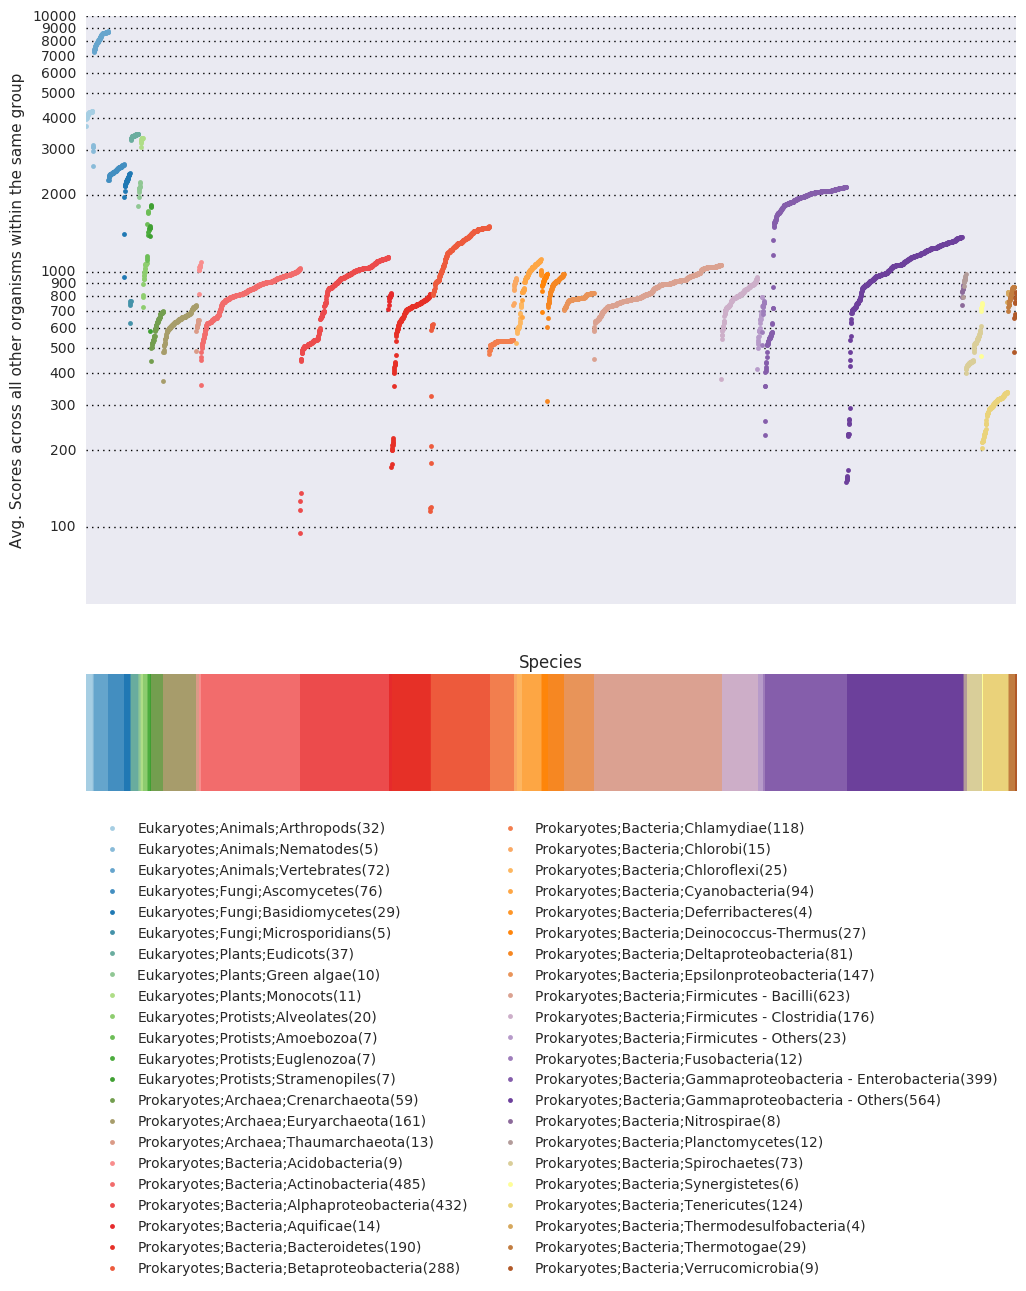

In [11]:
def drawScoreDistributions(table, unitaxa, xsize):
    # set up the color scale
    valtaxa = np.zeros(xsize)
    gradient = np.linspace(0, 1, len(unitaxa))

    plt.close("all")

    fig = plt.figure(figsize=(12,10))
    gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[5, 1])
#     fig = plt.figure(figsize=(15,15))
#     gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[6,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    axes = [ax1, ax2]
    colormap=plt.get_cmap('Paired')
    pre_idx = 0
    rst = pd.DataFrame()
    for i in range(len(unitaxa)):
        taxinfo = unitaxa[i].split(';')
#         print(unitaxa[i])
        t = table[taxinfo[0], taxinfo[1], taxinfo[2]].loc[taxinfo[0], taxinfo[1], taxinfo[2]]
        last_idx = pre_idx
        pre_idx += t.shape[0]
        valtaxa[last_idx:pre_idx] = gradient[i]
        p = np.mean(t, axis=0) * (t.shape[0])/(t.shape[0]-1)
        s_idx = np.argsort(p)
        df = pd.DataFrame(p[s_idx])
        df['taxa'] = unitaxa[i]
        df.set_index('taxa', append=True, inplace=True)
        rst = rst.append(df)
        axes[0].plot(range(last_idx,pre_idx), p[s_idx], '.', color=colormap(gradient[i]), label=unitaxa[i]+"("+str(t.shape[0])+")")
    axes[0].axis([0, xsize, 50, 10000])
    axes[0].grid(True, color='k', linestyle='dotted', clip_on=True)
    
    axes[0].set_yscale("log", nonposx='clip')
    axes[0].set_ylabel("Avg. Scores across all other organisms within the same group")
    axes[0].get_xaxis().set_ticks([])
    
    xlab = list(range(100,1000,100))
    xlab+=list(range(1000,11000,1000))
    
    axes[0].get_yaxis().set_ticks(xlab)
    axes[0].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     axes[0].set_ylabels(range(100,1000,100))
    
    valtaxa = np.vstack((valtaxa, valtaxa))
    
    pcm = axes[1].imshow(valtaxa, aspect='auto', cmap=colormap)
    axes[1].set_axis_off()
    axes[1].set_title("Species")
    lgd = axes[0].legend(bbox_to_anchor=(0, -0.35), loc='upper left', ncol=2)
    fig.savefig('bsf_kegg_scores_taxa123_ingroup_avg_4_i_v2_log.eps', format='eps', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    
#     rst.to_csv('bsf_kegg_scores_taxa123_ingroup_avg_4_i.txt', sep='\t')
    plt.show()
    plt.close()

## the average scores across organisms within the same groups
unitaxa = np.unique(np.array(fixed_kegg_orgs[['taxa123']]).flatten())
filtered_unitaxa = []
#### cut-off the small groups ####
ignoreList = ['Prokaryotes;Bacteria;Other','Prokaryotes;Bacteria;Other proteobacteria','Prokaryotes;Bacteria;Unclassified Bacteria']
xsize = 0
for i in range(len(unitaxa)):
    if unitaxa[i] in ignoreList:
        continue
    taxinfo = unitaxa[i].split(';')
    t = bigtable[taxinfo[0], taxinfo[1], taxinfo[2]]
    t = t.loc[taxinfo[0], taxinfo[1], taxinfo[2]]
    if t.shape[0] > 3:
        filtered_unitaxa.append(unitaxa[i])
        xsize += t.shape[0]
###################################
drawScoreDistributions(bigtable, filtered_unitaxa, xsize)

In [ ]:
sym_mat = np.zeros((ncols, ncols))
for i in range(ncols):
    for j in range(ncols):
        if i < j:
            sym_mat[i,j] = rst_mat[i,j]
        elif i > j:
            sym_mat[i,j] = rst_mat[j,i]
        else:
            sym_mat[i,j] = np.sum(kegg_ko_org_mat[:,i])

In [ ]:
## correction!!
# we need to eliminate the all 0 columns (organisms having no KO)
sum_dist = np.sum(sym_mat, axis=0)
_sym_mat = np.delete(sym_mat, np.where(sum_dist==0), 0)
_sym_mat = np.delete(_sym_mat, np.where(sum_dist==0), 1)
print(sym_mat.shape)
print(_sym_mat.shape)
print(len(np.where(sum_dist==0)[0]), 'organisms deleted')

norgs = _sym_mat.shape[0]

In [ ]:
## calculate the correlation between family-vs-family
# taxa = np.array(fixed_kegg_orgs[['taxa123']]).flatten()
# unitaxa = np.unique(taxa)
# ngroups = len(unitaxa)
# print('There are ', ngroups, ' groups for', norgs, 'organisms')

tuples = list(zip(np.array(fixed_kegg_orgs[['taxa1']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa2']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa3']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa4']]).flatten(),
                  np.array(fixed_kegg_orgs[['name']]).flatten()))

m_index = pd.MultiIndex.from_tuples(tuples, names=['Lv1', 'Lv2', 'Lv3', 'Lv4', 'name'])
bigtable = pd.DataFrame(_sym_mat, index=m_index, columns=m_index)

In [ ]:
_kegg_orgs = kegg_orgs.drop(kegg_orgs.index[np.where(sum_dist==0)])
print(_kegg_orgs.shape)
fixed_kegg_orgs = _kegg_orgs.reindex(range(norgs))
# fixed_kegg_orgs

In [ ]:
# average distances of each organism
# avg_dist_org = np.sum(_sym_mat, axis=0) / (ncols-1)
avg_dist_org = np.mean(_sym_mat, axis=0)
sort_idx = np.argsort(avg_dist_org)
sort_idx.shape

In [ ]:
np.array(_kegg_orgs[['taxa123']]).flatten()

In [ ]:
## the average scores across all the organisms
import matplotlib
import matplotlib.pyplot as plt

taxa_level = 'taxa123'
taxa = np.array(_kegg_orgs[[taxa_level]]).flatten()
index = np.lexsort((avg_dist_org, taxa))
_taxa = taxa[index]
_avg_dist_org = avg_dist_org[index]

unitaxa = np.unique(_taxa)
_unitaxa = []

#### cut-off the small groups ####
ignoreList = ['Prokaryotes;Bacteria;Other','Prokaryotes;Bacteria;Other proteobacteria','Prokaryotes;Bacteria;Unclassified Bacteria']
for i in range(len(unitaxa)):
    idx_t, = np.where(_taxa==unitaxa[i])
    if (len(idx_t) > 3) & (unitaxa[i] not in ignoreList):
        _unitaxa.append(unitaxa[i])
    else:
        _taxa = np.delete(_taxa, idx_t)
        # print(idx_t, _taxa.shape)
        _avg_dist_org = np.delete(_avg_dist_org, idx_t)
# print(_unitaxa)
print('There are', len(unitaxa), 'groups for', norgs, 'organisms.')
print('After deleting the small groups (size <= 3), we have', len(_unitaxa), 'groups for', len(_taxa), 'organisms.')
###################################

valtaxa = np.zeros(len(_taxa))
gradient = np.linspace(0, 1, len(_unitaxa))

for i in range(len(_unitaxa)):
    valtaxa[np.where(_taxa==_unitaxa[i])] = gradient[i]

valtaxa = np.vstack((valtaxa, valtaxa))

plt.close("all")

fig = plt.figure(figsize=(20,12))
gs = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[6,1], width_ratios=[5,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])

axes = [ax1, ax2]
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
colormap=plt.get_cmap('Paired')

for i in range(len(_unitaxa)):
    idx_t, = np.where(_taxa==_unitaxa[i])
    if len(idx_t) > 2:
        axes[0].plot(idx_t, _avg_dist_org[idx_t], '.', color=colormap(gradient[i]), label=_unitaxa[i]+"("+str(len(idx_t))+")")
axes[0].axis([0, len(_taxa), 0, 1000])
axes[0].set_ylabel("Avg. Scores across all other organisms")
axes[0].get_xaxis().set_ticks([])
pcm = axes[1].imshow(valtaxa, aspect='auto', cmap=colormap)
axes[1].set_axis_off()
axes[1].set_title("Species")
axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.savefig('bsf_kegg_scores_taxa123_overall_avg_4_i.png')
plt.show()
plt.close()

In [ ]:
## the average scores across organisms within the same groups
import matplotlib
import matplotlib.pyplot as plt

taxa_level = 'taxa123'
taxa = np.array(_kegg_orgs[[taxa_level]]).flatten()
index = np.lexsort((avg_dist_org, taxa))
_taxa = taxa[index]
_avg_dist_org = avg_dist_org[index]
mat = _sym_mat[index, :]
mat = mat[:, index]

unitaxa = np.unique(_taxa)
_unitaxa = []

#### cut-off the small groups ####
ignoreList = ['Prokaryotes;Bacteria;Other','Prokaryotes;Bacteria;Other proteobacteria','Prokaryotes;Bacteria;Unclassified Bacteria']
for i in range(len(unitaxa)):
    idx_t, = np.where(_taxa==unitaxa[i])
    if (len(idx_t) > 3) & (unitaxa[i] not in ignoreList):
        _unitaxa.append(unitaxa[i])
    else:
        _taxa = np.delete(_taxa, idx_t)
        _avg_dist_org = np.delete(_avg_dist_org, idx_t)
        mat = np.delete(mat, idx_t, 0)
        mat = np.delete(mat, idx_t, 1)

# print(_unitaxa)
print(mat.shape)
print('There are', len(unitaxa), 'groups for', norgs, 'organisms.')
print('After deleting the small groups (size <= 3), we have', len(_unitaxa), 'groups for', len(_taxa), 'organisms.')
###################################

In [ ]:
valtaxa = np.zeros(len(_taxa))
gradient = np.linspace(0, 1, len(_unitaxa))

for i in range(len(_unitaxa)):
    valtaxa[np.where(_taxa==_unitaxa[i])] = gradient[i]

valtaxa = np.vstack((valtaxa, valtaxa))

In [ ]:
plt.close("all")

fig = plt.figure(figsize=(20,12))
gs = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[6,1], width_ratios=[5,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])

axes = [ax1, ax2]
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
colormap=plt.get_cmap('Paired')

for i in range(len(_unitaxa)):
    idx_t, = np.where(_taxa==_unitaxa[i])
    if len(idx_t) > 2:
        axes[0].plot(idx_t, np.sort(np.sum(mat[idx_t,:][:,idx_t], axis=0) / (len(idx_t))), '.', color=colormap(gradient[i]), label=_unitaxa[i]+"("+str(len(idx_t))+")")
axes[0].axis([0, len(_taxa), 0, 4500])
axes[0].set_ylabel("Avg. Scores across all other organisms within the same group")
axes[0].get_xaxis().set_ticks([])
pcm = axes[1].imshow(valtaxa, aspect='auto', cmap=colormap)
axes[1].set_axis_off()
axes[1].set_title("Species")
axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.savefig('bsf_kegg_scores_taxa123_ingroup_avg_4_i.png')
plt.show()
plt.close()

In [ ]:
def drawScoreDistributions(table, unitaxa, xsize):
    # set up the color scale
    valtaxa = np.zeros(xsize)
    gradient = np.linspace(0, 1, len(unitaxa))

    plt.close("all")

    fig = plt.figure(figsize=(20,12))
    gs = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[6,1], width_ratios=[5,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])

    axes = [ax1, ax2]
    colormap=plt.get_cmap('Paired')
    pre_idx = 0
    rst = pd.Series()
    for i in range(len(unitaxa)):
        taxinfo = unitaxa[i].split(';')
        print(unitaxa[i])
        t = table[taxinfo[0], taxinfo[1], taxinfo[2]]
        t = t.loc[taxinfo[0], taxinfo[1], taxinfo[2]]
        last_idx = pre_idx
        pre_idx += t.shape[0]
        valtaxa[last_idx:pre_idx] = gradient[i]
        p = np.mean(t, axis=0)
        s_idx = np.argsort(p)
        rst = rst.append(p[s_idx])
        axes[0].plot(range(last_idx,pre_idx), p[s_idx], '.', color=colormap(gradient[i]), label=_unitaxa[i]+"("+str(t.shape[0])+")")
    axes[0].axis([0, xsize, 0, 2500])
    axes[0].set_ylabel("Avg. Scores across all other organisms within the same group")
    axes[0].get_xaxis().set_ticks([])
    
    valtaxa = np.vstack((valtaxa, valtaxa))
    
    pcm = axes[1].imshow(valtaxa, aspect='auto', cmap=colormap)
    axes[1].set_axis_off()
    axes[1].set_title("Species")
    axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.savefig('bsf_kegg_scores_taxa123_ingroup_avg_4_i.png')
    
    print(rst)
    rst.to_csv('bsf_kegg_scores_taxa123_ingroup_avg_4_i.txt', sep='\t')
    plt.show()
    plt.close()

## the average scores across organisms within the same groups
unitaxa = np.unique(np.array(_kegg_orgs[['taxa123']]).flatten())
filtered_unitaxa = []
#### cut-off the small groups ####
ignoreList = ['Prokaryotes;Bacteria;Other','Prokaryotes;Bacteria;Other proteobacteria','Prokaryotes;Bacteria;Unclassified Bacteria']
xsize = 0
for i in range(len(unitaxa)):
    if unitaxa[i] in ignoreList:
        continue
    taxinfo = unitaxa[i].split(';')
    t = bigtable[taxinfo[0], taxinfo[1], taxinfo[2]]
    t = t.loc[taxinfo[0], taxinfo[1], taxinfo[2]]
    if t.shape[0] > 3:
        filtered_unitaxa.append(unitaxa[i])
        xsize += t.shape[0]
###################################
drawScoreDistributions(bigtable, filtered_unitaxa, xsize)

In [ ]:
table.index[0]

In [ ]:
# show me the "Firmicutes - Bacilli" vs "Firmicutes - Bacilli"
taxa_lv3 = 'Firmicutes - Bacilli'
bacilli_idx, = np.where(fixed_kegg_orgs['taxa3']=='Firmicutes - Bacilli')
bacilli_orgs = fixed_kegg_orgs.iloc[bacilli_idx]
_bacilli_groups = np.unique(np.array(fixed_kegg_orgs.iloc[bacilli_idx][['tree']]).flatten())
bacilli_orgs = bacilli_orgs.sort(['tree'])
bacilli_groups = _bacilli_groups

#### cut-off the small groups ####
bacilli_groups = []
for i in range(len(_bacilli_groups)):
    idx_t, = np.where(bacilli_orgs['tree']==_bacilli_groups[i])
    if len(idx_t) > 3:
        bacilli_groups.append(_bacilli_groups[i])
    else:
        bacilli_orgs = bacilli_orgs[bacilli_orgs['tree']!=_bacilli_groups[i]]

print('After deleting the small groups (size <= 2), we have', len(bacilli_groups), 'groups for', bacilli_orgs.shape[0], 'organisms.')
###################################


In [ ]:
print(bacilli_orgs.index)
print(_sym_mat)
bacilli_mat = _sym_mat[bacilli_orgs.index, :]
bacilli_mat = bacilli_mat[:, bacilli_orgs.index]
bacilli_mat

In [ ]:
valtaxa = np.zeros(bacilli_orgs.shape[0])
gradient = np.linspace(0, 1, len(bacilli_groups))

for i in range(len(bacilli_groups)):
    valtaxa[np.where(bacilli_orgs['tree']==bacilli_groups[i])] = gradient[i]

valtaxa = np.vstack((valtaxa, valtaxa))

plt.close("all")

fig = plt.figure(figsize=(20,12))
gs = matplotlib.gridspec.GridSpec(2, 2, height_ratios=[6,1], width_ratios=[5,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])

axes = [ax1, ax2]
colormap=plt.get_cmap('Paired')

for i in range(len(bacilli_groups)):
    idx_t, = np.where(bacilli_orgs['tree']==bacilli_groups[i])
#     print(idx_t, np.sum(bacilli_mat[idx_t,:], axis=1))
    axes[0].plot(idx_t, np.sort(np.sum(bacilli_mat[idx_t,:][:,idx_t], axis=1) / (len(idx_t)-1)), '.', color=colormap(gradient[i]), label=bacilli_groups[i]+"("+str(len(idx_t))+")")
axes[0].axis([0, bacilli_orgs.shape[0], 0, 2000])
axes[0].set_ylabel("Avg. Scores across all other organisms within the same group")
# axes[0].get_xaxis().set_ticks([])
pcm = axes[1].imshow(valtaxa, aspect='auto', cmap=colormap)
axes[1].set_axis_off()
axes[1].set_title("Species")
axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.savefig('bsf_kegg_scores_Firmicutes_Bacilli_ingroup_avg_4.png')
plt.show()
plt.close()

In [ ]:
threshold = 100
print(avg_dist_org[avg_dist_org<threshold])
_kegg_orgs[avg_dist_org<threshold]
np.unique(np.array(_kegg_orgs[_kegg_orgs['taxa3']=='Firmicutes - Bacilli']['taxa4']).flatten())

In [ ]:
colormap=plt.get_cmap('Paired')
def drawHeatmapMatrix(table, index_level, filename = 'heatmap.png', cmap = colormap, vmin=None, vmax=None):
    plt.close("all")
    # Create a custom palette to identify the networks
    groups = np.unique(table.index.get_level_values(index_level))
    t_pal = sns.diverging_palette(240, 10, n=len(groups))
#     t_pal = sns.cubehelix_palette(len(groups),
#                                   light=.9, dark=.1, reverse=True,
#                                   start=1, rot=-2)
    t_lut = dict(zip(map(str, groups), t_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    t_colors = pd.Series(table.index.get_level_values(index_level), index=table.columns).map(t_lut)
    # Create a custom colormap for the heatmap values
#     cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
    # Draw the full plot
    cg = sns.clustermap(table, row_colors=t_colors, linewidths=0,
                   col_colors=t_colors, figsize=(20, 20), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.savefig(filename)
    plt.show()

In [ ]:
table = bigtable['Prokaryotes','Bacteria','Firmicutes - Bacilli']
table = table.loc['Prokaryotes','Bacteria','Firmicutes - Bacilli']
drawHeatmapMatrix(table, 'Lv4', 'Firmicutes_Bacilli_clustermap.png')

In [ ]:
grouped = bigtable.groupby(level=[1,2]).mean()
grouped = grouped.groupby(level=[1,2], axis=1).mean()
# grouped = pd.DataFrame(np.log(grouped.values), index=grouped.index, columns=grouped.columns)

drawHeatmapMatrix(grouped, 'Lv2', 'overall_heatmap.png', plt.get_cmap('OrRd'),vmin=0, vmax=3000)

In [12]:
# draw the heatmap for 'Firmicutes - Bacilli'
table = bigtable['Prokaryotes','Bacteria','Firmicutes - Bacilli']
table = table.loc['Prokaryotes','Bacteria','Firmicutes - Bacilli']

lv4 = np.unique(table.index.get_level_values(0))
grouped = np.zeros((len(lv4),len(lv4)))
labels_1 = []
labels = []
for i in range(len(lv4)):
    for j in range(i, len(lv4)):
        part = table[lv4[i]].loc[lv4[j]]
        nrows, ncols = part.shape

        if i == j:
            labels.append(lv4[i] + "("+str(nrows)+")")
            if nrows == 1: labels_1.append(lv4[i])
#             labels.append(lv4[i] + "_"+str(nrows))
            if (nrows == 1) & (ncols == 1):
#                 print(i, j, lv4[i], lv4[j])
                grouped[j,i] = np.nan
                continue
            grouped[j,i] = np.sum(np.sum(part))/(nrows*(nrows-1))
        else:
            grouped[j,i] = np.sum(np.sum(part))/(nrows*ncols)
            grouped[i,j] = grouped[j,i]
grouped = pd.DataFrame(grouped, columns=labels, index=labels)
median = grouped.median().median()
maxval = grouped.max().max()

grouped.to_csv('Firmicutes_Bacilli_heatmap.csv', sep='\t')

#
# draw the heatmap for 'Firmicutes - Bacilli'
grouped_1 = np.zeros((len(labels_1),len(labels_1)))
labels = []
for i in range(len(labels_1)):
    for j in range(i, len(labels_1)):
        part = table[labels_1[i]].loc[labels_1[j]]
        nrows, ncols = part.shape
        
        if nrows > 1: continue
        
        if i == j:
            labels.append(labels_1[i] + "_"+str(nrows))
            if (nrows == 1) & (ncols == 1):
                grouped_1[j,i] = np.nan
                continue
            grouped_1[j,i] = np.sum(np.sum(part))/(nrows*(nrows-1))
        else:
            grouped_1[j,i] = np.sum(np.sum(part))/(nrows*ncols)
            grouped_1[i,j] = grouped_1[j,i]
            
print(labels_1)
            
grouped_1 = pd.DataFrame(grouped_1, columns=labels, index=labels)
median = grouped_1.median().median()
maxval = grouped_1.max().max()

grouped_1.to_csv('Firmicutes_Bacilli_heatmap_with_phylog.csv', sep='\t')

/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  app.launch_new_instance()


['Amphibacillus', 'Aneurinibacillus', 'Gemella', 'Halobacillus', 'Jeotgalibacillus', 'Kurthia', 'Kyrpidia', 'Lentibacillus', 'Macrococcus', 'Marinilactibacillus', 'Oceanobacillus', 'Oenococcus', 'Rummeliibacillus', 'Salimicrobium', 'Salinicoccus', 'Sporosarcina', 'Terribacillus', 'Tetragenococcus', 'Thermobacillus', 'Unclassified Sporolactobacillaceae', 'Vagococcus']


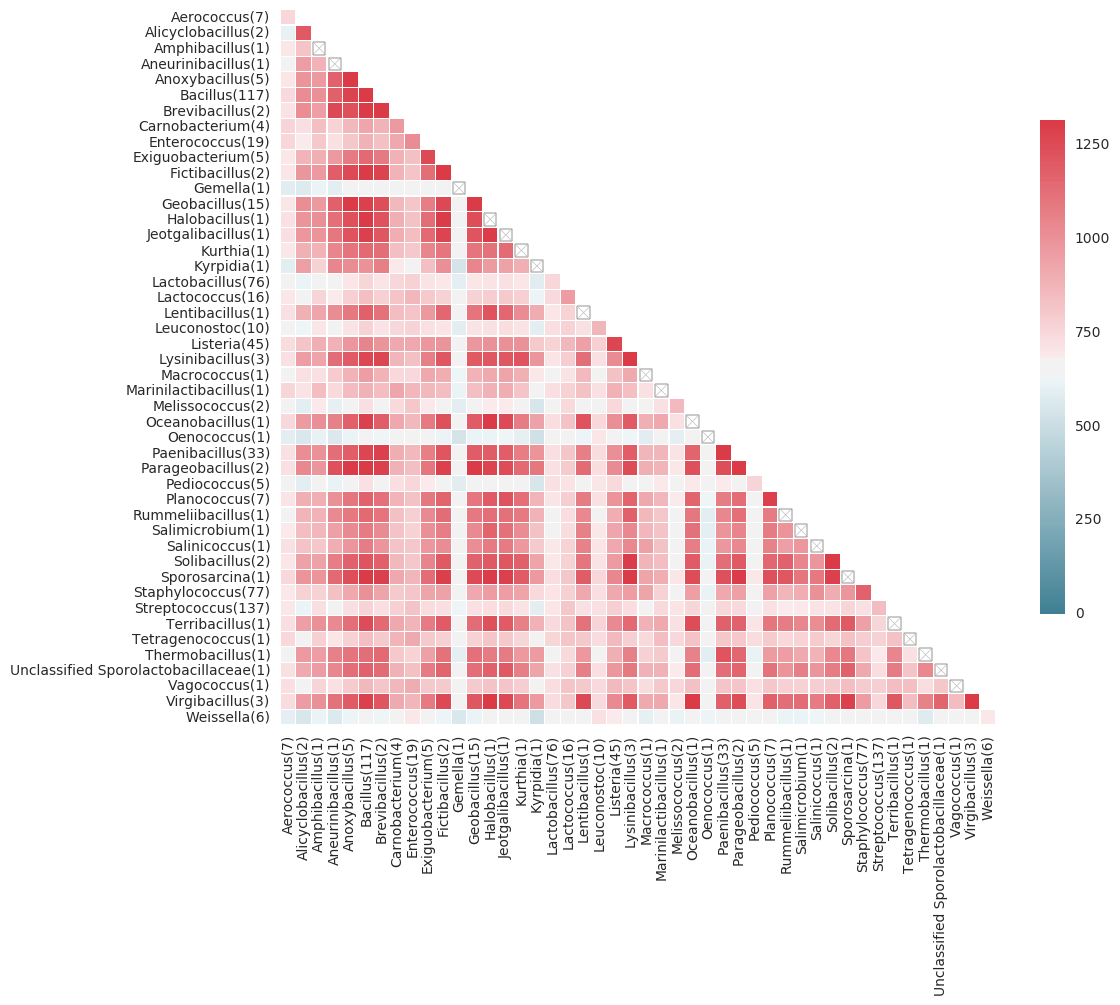

In [13]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(grouped, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
cg=sns.heatmap(grouped, mask=mask, cmap=cmap, vmax=maxval,vmin=0,
            square=True, #xticklabels=5, yticklabels=5,
            linewidths=.1, cbar_kws={"shrink": .5}, ax=ax)
ilist, ilist = np.where(grouped.isnull())
for i in ilist:
    cg.add_patch(matplotlib.patches.Rectangle((i+0.1,45-i+0.1),0.8,0.8, fill=False))
    cg.plot([i+0.1,i+0.9], [45-i+0.1,45-i+0.9], '-', lw=.5, color = '0.75')
    cg.plot([i+0.9,i+0.1], [45-i+0.1,45-i+0.9], '-', lw=.5, color = '0.75')
plt.tight_layout()
plt.savefig("Firmicutes_Bacilli_heatmap.png")
plt.show()

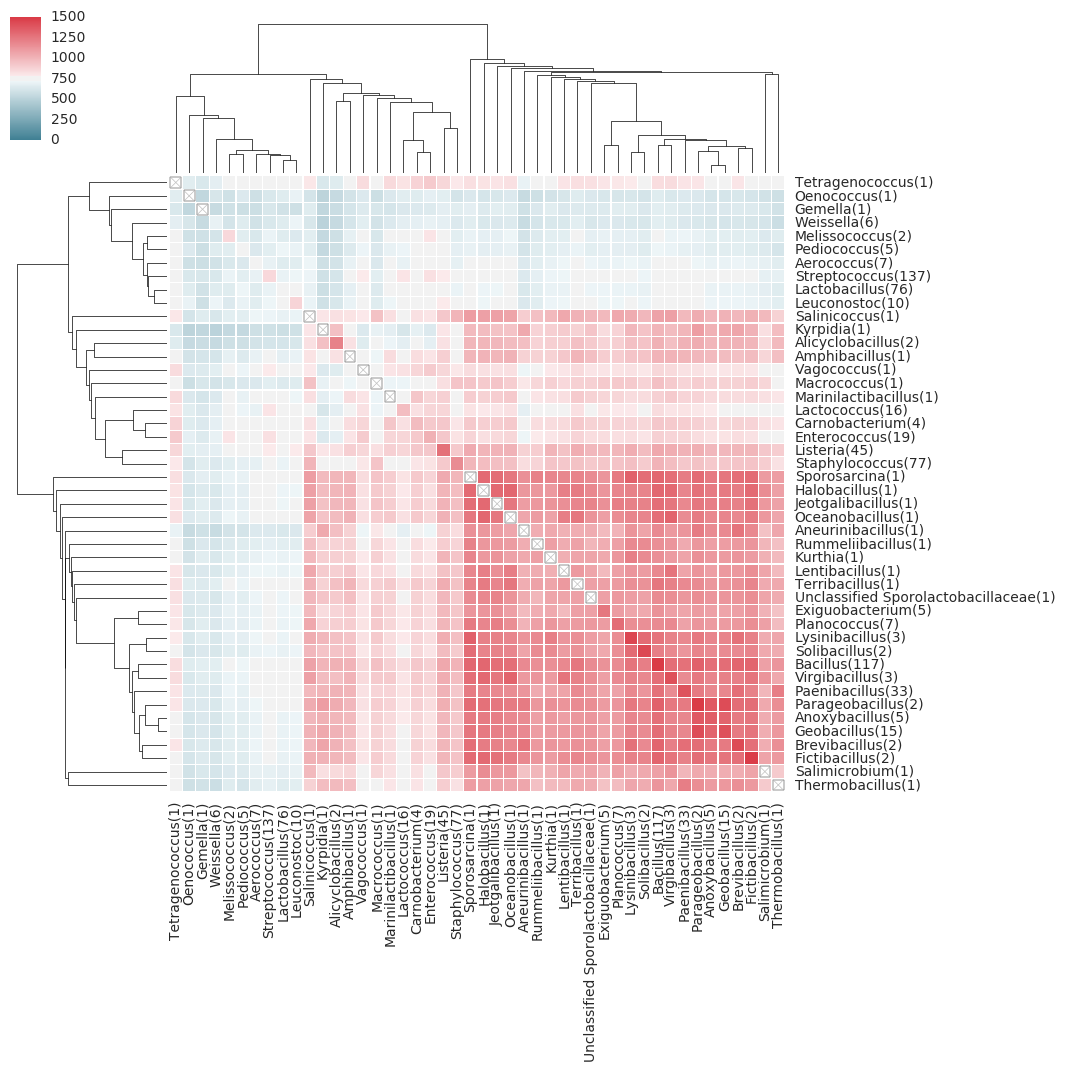

In [14]:
plt.close('all')
grouped[grouped.isnull()] = -1
cg = sns.clustermap(grouped, cmap=cmap, vmax=1500,vmin=0,
            square=True, linewidths=.1, mask=(grouped<0))

ilist, ilist = np.where(cg.data2d<0)
for i in ilist:
    cg.ax_heatmap.add_patch(matplotlib.patches.Rectangle((i+0.1,45-i+0.1),0.8,0.8, fill=False))
    cg.ax_heatmap.plot([i+0.1,i+0.9], [45-i+0.1,45-i+0.9], '-', lw=.5, color = '0.75')
    cg.ax_heatmap.plot([i+0.9,i+0.1], [45-i+0.1,45-i+0.9], '-', lw=.5, color = '0.75')

plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg.savefig("Firmicutes_Bacilli_clustered_heatmap.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()